## Import packages

In [328]:
# Essential packages for neural networks
import torch
import torch.nn as nn
import torch.nn.functional as fn

# Gradient descent
import torch.optim as optim 

# Visualization
from PIL import Image
import matplotlib.pyplot as plt

# Convert image to tensor
import torchvision.transforms as transforms

# Models
from torchvision.models import vgg19, VGG19_Weights

import copy

In [329]:
# Check if GPU is availalbe

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device=device)

print('Device:', device)

Device: cuda


# Load images

In [330]:
# Produce larger image if we have GPU
img_size = 512 if torch.cuda.is_available() else 128

# Resize and transform to tensor
loader = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name)

    image = loader(image).unsqueeze(0)

    # Cast tensor of ints to tensor floats
    return image.to(device, torch.float)

style_img = image_loader('./data/express.jpg')
content_img = image_loader('./data/cat.jpg')

assert style_img.size() == content_img.size()

## Breakdown of `image_loader` function

In [331]:
tmp_img = Image.open('data/express.jpg')

# Verify that an image is resized according to device (gpu or cpu)
tmp_resized = transforms.Resize(img_size)(tmp_img)
print(tmp_resized)

<PIL.Image.Image image mode=RGB size=512x512 at 0x1ED07EF09D0>


In [332]:
tmp_tensor = transforms.ToTensor()(tmp_resized)

# Examine shape of the tensor
print(tmp_tensor.shape)

torch.Size([3, 512, 512])


In [333]:
tmp_unsqueezed = tmp_tensor.unsqueeze(0)

# This adds one extra dimension to the image
# which turns our data into a batch of images that has only 1 image
print(tmp_unsqueezed.shape)

torch.Size([1, 3, 512, 512])


## Display images

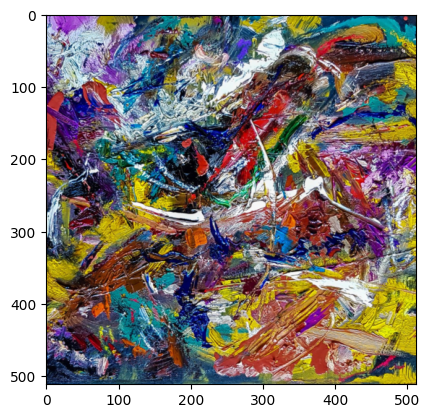

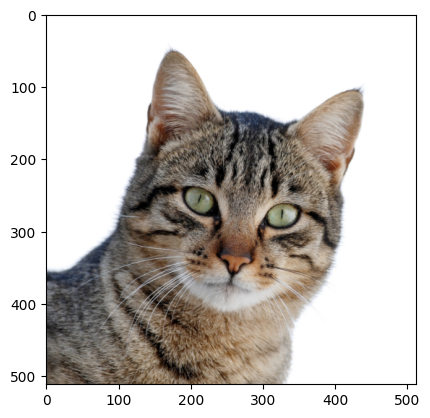

In [334]:
unloader = transforms.ToPILImage()

plt.ion()

def show_img(tensor):
    # Clone image to avoid changing the tensor
    image = tensor.cpu().clone()

    # Restore original dimension
    image = image.squeeze(0)

    # Tensor to PIL
    image = unloader(image)

    plt.imshow(image)

plt.figure()
show_img(style_img)

plt.figure()
show_img(content_img)

# Loss functions

In [335]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = fn.mse_loss(input, self.target)

        return input

In [336]:
def gram_matrix(input):
    a, b, c, d = input.size()  
    # a: batch size (1)
    # b: number of feature maps (3 channels)
    # (c,d): dimensions 

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = fn.mse_loss(G, self.target)
        return input

# Import model

In [337]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Since VGG are trained on images where each channel is normalized, we need to do it to the images before running the model.

In [338]:
norm_mean = torch.tensor([ 0.485, 0.456, 0.406 ])
norm_std = torch.tensor([ 0.229, 0.224, 0.225 ])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

This part is complicated. According to Pytorch documentation, we need to add content loss and style loss layers **after** the convulution layer theya re detecting.

In [339]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        # This code checks each layer in the CNN and generates the corresponding name
        # We cross check a layer's name against our desired layer to decide what to do with our loss functions
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) -1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

# Gradient descent

In [340]:
# Use LBFGS algorithm to optimize learning process
# The goal is to minimize content loss and style loss

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

Now we run gradient descent using Pytorch's programming pattern.

In [341]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [345]:
output = run_style_transfer(cnn, norm_mean, norm_std, content_img, style_img, content_img.clone(), num_steps=400)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 437.325684 Content Loss: 50.610661

run [100]:
Style Loss : 130.634720 Content Loss: 51.251804

run [150]:
Style Loss : 53.486904 Content Loss: 50.828072

run [200]:
Style Loss : 24.327866 Content Loss: 50.049706

run [250]:
Style Loss : 13.126710 Content Loss: 49.128635

run [300]:
Style Loss : 7.443836 Content Loss: 47.082680

run [350]:
Style Loss : 5.086071 Content Loss: 45.117268

run [400]:
Style Loss : 3.837581 Content Loss: 43.450737



In [346]:
output.shape

torch.Size([1, 3, 512, 512])

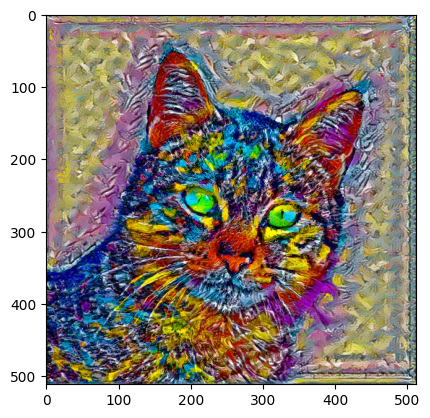

In [347]:
plt.figure()
show_img(output)